### Nonlinear flow data handling using Total-Variation Regularization
Many researchers note the nonlinearity of flow in tight rocks. This manifests itself in the form of a decrease in effective permeability with a decrease in flow rate. For low-permeable rocks, the estimation of reservoir permeability without taking into account the nonlinearity of the flow can yield significant errors. Accounting for non-linear flow can also lower the estimate of reservoir productivity and lead to an increase in stationary oil zone estimation. Regular methods of studying fluid flows in porous rocks are poorly suited to study their permeability when approaching to zero fluxes. Previously, we proposed a method for laboratory testing of non-linear flow in low-permeability rock samples, based on measuring flux during a slow decline in the pore pressure gradient. A feature of the proposed technique is that the flow rate of the liquid is measured by its continuous weighing. This method of measurement allows us to study very slow flows, but it requires a special approach to calculating the flow rate from mass change data. One of these approaches is the Total-Variation Regularization method, which is often used in the problems of filtering noise in images. We investigated the possibility of using this method to analyze the results of measuring infinitesimal flow rates based on the mass change. As a result, it was shown that this method has a number of advantages, and in combination with the proposed modification of the quality functional, it allows processing significantly irregular data. The method proposed by us can be used in research work for a more accurate assessment of the permeability of dense rocks, the filtration properties of which can be significantly non-linear.
Here is an example of handling data on mass and pore pressure gradient vs time data in a pressure decay test to obtain the effective permeability.

Imports first.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import t as stu
import matplotlib.pyplot as plt
from pkg.methods import sav_gol_deriv, jackknife_tvr

Next reading Data

In [27]:
df = pd.read_hdf('Data/data.h5', key='df')
params = pd.read_hdf('Data/data.h5', key='params')

S = params['S, cm^2'][0] # cross-section
ro = params['ro, g/cm^3'][0] # density, g/cm3
mu = params['mu, g/cm*s'][0] # visc., c/cm*s2

time = df['Time (s)'].to_numpy() # time (sec)
m = df['Mass (g)'].to_numpy() # mass (g)
gP = df['gradP (MPa/m)'].to_numpy() # pore pressure gradient

Using total-variance regularization (TVR) and Savitsky-Golay (SG) methods for smoothing the experimental data of the liquid mass on time and calculating its flow rate.
' mode=1 ' means using of modified loss function:
$ F_{mod} = \gamma \sum_{i}\left | {u_{i} - u_{i - 1}  }\right |+\sum_{i}{\left | {\sum_{j=1}^{i}{u_j\Delta x_j-f_i}} \right |^2} $

where $f(x)$ is initial function, $u$ is derivative to find, $\gamma$ - regularization parameter.

In [28]:
# meta params
sg_window = 7 # window for SG smoothing
tvr_gamma = 1 # gamma param for TVR
ds = time > 750 # desired data slice

# mass to mass rate via TVR
m_tvr, m_tvr_stats, Q_tvr, Q_tvr_stats = jackknife_tvr(m[ds], time[ds], 2, gamma=tvr_gamma, mode=1) # TVR and jackknife stats
Q_tvr_sigma = Q_tvr_stats['se_jack']
m_tvr_sigma = m_tvr_stats['se_jack']

dof = len(time[ds])-1
ts = stu.ppf(0.975, dof) # 95% confidence level
m_tvr_CI = ts * m_tvr_sigma # Confidence interval
Q_tvr_CI = ts * Q_tvr_sigma

# mass to mass rate via SG
m_sg, m_sg_sigma, Q_sg, Q_sg_sigma = sav_gol_deriv(m[ds], time[ds], window=sg_window)

dof = sg_window-2
ts = stu.ppf(0.975, dof) # 95% confidence level
m_sg_CI = ts * m_sg_sigma * np.sqrt(1/sg_window) # Confidence interval for the mean
Q_sg_CI = ts * Q_sg_sigma

# mass to mass rate via vanilla gradient (second order accurate central differences f(x + ∆x) − f(x − ∆x)/(2∆x)
Q_grad = np.gradient(m[ds], time[ds])

# raw data m ant t
t = time[ds]
m_exp = m[ds]

Plotting of fluid mass smoothing results $m$ and flow rate calculation $Q$ via both TVR and SG. $Q_{diff}$ is the mass flow rate, calculated by the central difference method. $CI$ is the 95% confidence interval estimate for each of the methods.

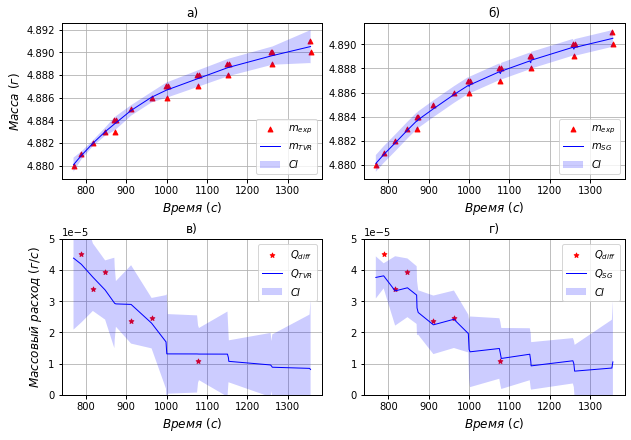

In [29]:
''' plots mass smoothing: tvr vs sg '''
fig, ((ax_m1, ax_m2), (ax_q1, ax_q2)) = plt.subplots(2,2, figsize=(2*4.33, 2*3), facecolor='white', constrained_layout=True)
axes = (ax_m1, ax_m2, ax_q1, ax_q2)
for ax in axes:
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xlabel(r'$Время\ (с)$', fontsize=12)


ax_m1.set_ylabel(r'$Масса\ (г)$', fontsize=12, rotation='vertical')
ax_q1.set_ylabel(r'$Массовый\ расход\ (г/с)$', fontsize=12, rotation='vertical')

# m tvr
ax_m1.scatter(x = t, y = m_exp, marker='^', color='r', s=24, linewidths=1)
ax_m1.plot(t, m_tvr, color = 'b', linewidth=1)
ax_m1.fill_between(t, m_tvr-m_tvr_CI, m_tvr+m_tvr_CI, color='b', alpha = 0.2, linestyle=':', linewidth=0.1)

# m SG
ax_m2.scatter(x = t, y = m_exp, marker='^', color='r', s=24, linewidths=1)
ax_m2.plot(t, m_sg, color = 'b', linewidth=1)
ax_m2.fill_between(t, m_sg-m_sg_CI, m_sg+m_sg_CI, color='b', alpha = 0.2, linestyle=':', linewidth=0.1)

# Q tvr
ax_q1.scatter(x = t, y = Q_grad, marker='*', color='r', s=24, linewidths=1)
ax_q1.plot(t, Q_tvr, color = 'b', linewidth=1)
ax_q1.fill_between(t, Q_tvr-Q_tvr_CI, Q_tvr+Q_tvr_CI, color='b', alpha = 0.2, linestyle=':', linewidth=0.1)
ax_q1.set_ylim([0, 5e-5])

# Q SG
ax_q2.scatter(x = t, y = Q_grad, marker='*', color='r', s=24, linewidths=1)
ax_q2.plot(t, Q_sg, color = 'b', linewidth=1)
ax_q2.fill_between(t, Q_sg-Q_sg_CI, Q_sg+Q_sg_CI, color='b', alpha = 0.2, linestyle=':', linewidth=0.1)
ax_q2.set_ylim([0, 5e-5])


ax_m1.legend([r'$m_{exp}$', r'$m_{TVR}$', r'$CI$'], loc = 'lower right')
ax_m2.legend([r'$m_{exp}$', r'$m_{SG}$', r'$CI$'], loc = 'lower right')
ax_q1.legend([r'$Q_{diff}$', r'$Q_{TVR}$', r'$CI$'], loc = 'upper right')
ax_q2.legend([r'$Q_{diff}$', r'$Q_{SG}$', r'$CI$'], loc = 'upper right')

ax_m1.set_title('а)', loc='center')
ax_m2.set_title('б)', loc='center')
ax_q1.set_title('в)')
ax_q2.set_title('г)')

for ax in axes[2:]:
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

for ax in axes:
    ax.tick_params(top=False, bottom=True, left = True, width=1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('black')

plt.savefig(f'Figure 3.png', dpi = 300,  bbox_inches='tight', transparent=False)

Using total-variance regularization (TVR) and Savitsky-Golay (SG) methods for the effective permeability calculation:
${k}_{eff} = \eta\frac{U}{gradP}  = \frac{\eta}{\rho S}\frac{U}{gradP}\frac{dm}{dt}$

In [30]:
# meta params
sg_window = 7 # for SG smoothng
tvr_gamma = 1 # gamma param for TVR
ds = gP < 0.3 # data slice

# mass to mass rate via TVR
m_tvr, m_tvr_stats, Q_tvr, Q_tvr_stats = jackknife_tvr(m[ds], time[ds], 2, gamma=tvr_gamma, mode=1) # TVR and jackknife stats
Q_tvr_sigma = Q_tvr_stats['se_jack']
m_tvr_sigma = m_tvr_stats['se_jack']

dof = len(time[ds])-1
ts = stu.ppf(0.975, dof) # 95% confidence level
m_tvr_CI = ts * m_tvr_sigma # Confidence interval
Q_tvr_CI = ts * Q_tvr_sigma

# mass to mass rate via SG
m_sg, m_sg_sigma, Q_sg, Q_sg_sigma = sav_gol_deriv(m[ds], time[ds], window=sg_window)

dof = sg_window-2
ts = stu.ppf(0.975, dof) # 95% confidence level
m_sg_CI = ts * m_sg_sigma * np.sqrt(1/sg_window) # Confidence interval for the mean
Q_sg_CI = ts * Q_sg_sigma

# mass to mass rate via vanilla gradient (second order accurate central differences f(x + ∆x) − f(x − ∆x)/(2∆x)
Q_grad = np.gradient(m[ds], time[ds])

# exp data m ant t
m_exp = m[ds]
t = time[ds]
gPs = gP[ds] # MPa/m

# effective permeability via TVR
k_tvr = 1e6 * mu * Q_tvr/(ro * S* gPs) # Darcy law, mD
k_tvr_CI = 1e6 * mu * Q_tvr_CI/(ro * S * gPs)

# effective permeability via SG
k_sg = 1e6 * mu * Q_sg/(ro * S* gPs) # Darcy law, mD
k_sg_CI = 1e6 * mu * Q_sg_CI/(ro * S * gPs)

# effective permeability via central difference
k_grad = 1e6 * mu * Q_grad/(ro * S * gPs)

Plotting of the effective permeability $k$ calculation results vs pore pressure gradient $gradP$ via both TVR and SG. $k_{diff}$ is calculated by the central difference method.

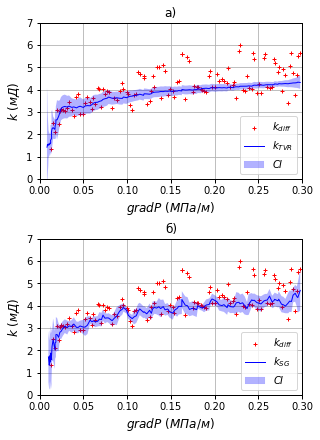

In [31]:
fig, (ax_k1, ax_k2) = plt.subplots(2,1, figsize=(4.33, 2*3), facecolor='white', constrained_layout=True)

axes = (ax_k1, ax_k2)
for ax in axes:
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xlabel(r'$gradP\ (МПа/м)$', fontsize=12)

ax_k1.set_ylabel(r'$k\ (мД)$', fontsize=12, rotation='vertical')
ax_k2.set_ylabel(r'$k\ (мД)$', fontsize=12, rotation='vertical')

ax_k1.scatter(x = gPs, y = k_grad, marker='+', color='r', s=24, linewidths=1)
ax_k1.plot(gPs, k_tvr, color = 'b', linewidth=1)
ax_k1.fill_between(gPs, k_tvr-k_tvr_CI, k_tvr+k_tvr_CI, color='b', alpha = 0.3, linestyle=':', linewidth=0.1)
ax_k1.set_ylim([0, 7])
ax_k1.set_xlim([0, 0.3])

tail = - sg_window//2 # 3 points at the end
ax_k2.scatter(x = gPs, y = k_grad, marker='+', color='r', s=24, linewidths=1)
ax_k2.plot(gPs[:tail], k_sg[:tail], color = 'b', linewidth=1)
ax_k2.fill_between(gPs[:tail], k_sg[:tail]-k_sg_CI[:tail], k_sg[:tail]+k_sg_CI[:tail], color='b', alpha = 0.3, linestyle=':', linewidth=0.1)
ax_k2.set_ylim([0, 7])
ax_k2.set_xlim([0, 0.3])

ax_k1.legend([r'$k_{diff}$', r'$k_{TVR}$', r'$CI$'], loc = 'lower right')
ax_k2.legend([r'$k_{diff}$', r'$k_{SG}$', r'$CI$'], loc = 'lower right')


ax_k1.set_title('a)', loc='center')
ax_k2.set_title('б)', loc='center')

for ax in axes:
    ax.tick_params(top=False, bottom=True, left = True, width=1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('black')

plt.savefig(f'Figure 4.png', dpi = 300,  bbox_inches='tight', transparent=False)

For more information please refer to [this work](https://doi.org/10.26006/22228535_2021_1_50)